# Week 3: CNN Cancer Detection Kaggle Mini-Project

For this week's mini-project, you will participate in this Kaggle competition: Histopathologic Cancer Detection

This Kaggle competition is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans

The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others' submissions. 

Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. As a mini-project to complete as a weekly assignment, we don't expect you to iterate over your project until you have a model capable of winning the challenge. The iterative process takes time, so please start early to get better-quality results and reports. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project. The grades are more based on the quality and depth of the analysis, not just on a better Kaggle score. 

## Step 1
**Brief description of the problem and data (5 pts)**

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.

In this project, I will use convolutional neural network to detect metastatic cancer in cells. 

The data is from Kaggle's histopathologic cancer detection competition. The data set contains RGB images with binary labels (having cancer vs not having cancer). The dataset has 220,025 images, in which I will take 80% for training and 20% for testing. 

The images in the dataset are .tif and have the shape of (96, 96, 3). According to Kaggle description, the label is positive if at least one pixel in the center (32, 32) contains tumorous tissue. 

The test dataset is unlabeled. 

## Step 2
**Exploratory Data Analysis (EDA) -- Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis.

In [21]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image
import sys
import os

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten
import itertools 

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Convert .tif image file to .png
def convert_png(new_img_dir, img_path, img_name):
    new_img_path = new_img_dir + img_name[:-4] + ".png"
    cur_img = Image.open(img_path + img_name)
    cur_img.save(new_img_path)
    cur_img.close()

In [9]:
# new directories for training images
train_neg_dir = "./train_png/negative_images/"
train_pos_dir = "./train_png/positive_images/"

os.makedirs("./train_png/")
os.makedirs(train_neg_dir)
os.makedirs(train_pos_dir)

In [18]:
train_labels_df = pd.read_csv("./train_labels.csv")
train_labels_l = list(train_labels_df.sort_values(by="id", axis=0)["label"])

# Convert .tif to .png
train_dir = "./train/"
train_imgs_l = os.listdir(train_dir)
train_imgs_l.sort()

for i in range(len(train_imgs_l)):
    #print(train_imgs_l[i])
    if train_labels_l[i] == 0:
        convert_png(train_neg_dir, train_dir, train_imgs_l[i])
    else:
        convert_png(train_pos_dir, train_dir, train_imgs_l[i])

In [3]:
# Build Keras Data object
train_data = tf.keras.utils.image_dataset_from_directory(directory="./train_png/", labels="inferred",
                                                         label_mode="binary", color_mode="rgb",
                                                         image_size=(96, 96), seed=42, batch_size=32)

Found 220025 files belonging to 2 classes.


2023-06-05 18:22:04.300875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-05 18:22:04.301399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

2023-06-05 18:23:43.221434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [220025]
	 [[{{node Placeholder/_4}}]]
2023-06-05 18:23:43.222032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [220025]
	 [[{{node Placeholder/_4}}]]


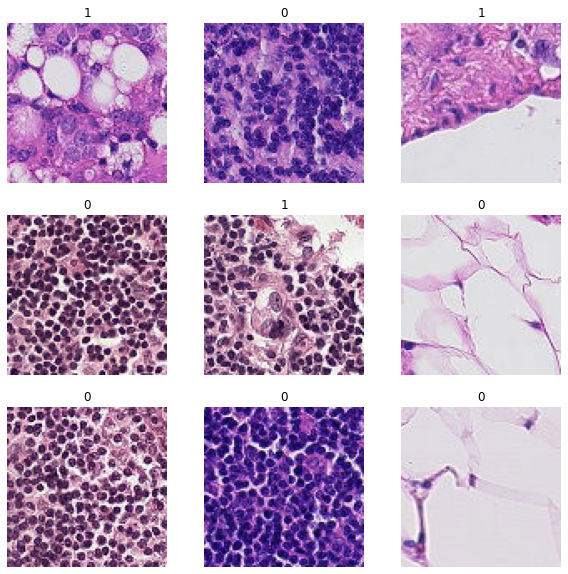

In [5]:
# Show some of the images
plt.figure(figsize=(10,10))
for imgs, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis('off')

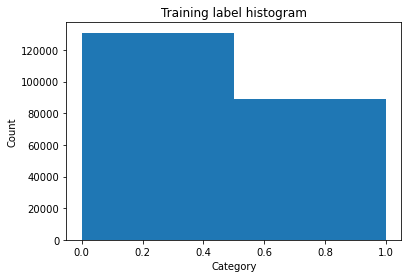

In [8]:
# Historgram of training labels
train_labels_df = pd.read_csv("./train_labels.csv")
train_labels_l = list(train_labels_df.sort_values(by="id", axis=0)["label"])

plt.hist(train_labels_l, bins=2)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Training label histogram")
plt.show()

## Step 3
**Model Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

n = 3: if n is too high, there would be overfitting

Activation function: ReLU vs PreLu. 

Optimization method: Adam, RMSProp

Learning rate: (0.0001, 0.001)

Dropout layers

Loss function: binary cross entropy

Logits: sigmoid activation

In [16]:
def model_build(eta, dropout_1, dropout_2, optimizer):
    batch_input_shape = (32, 96, 96, 3)
    model = tf.keras.Sequential()
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', batch_input_shape=batch_input_shape))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Flatten())
    if dropout_1 == True:
        model.add(Dropout(0.25))
        
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    if dropout_2 == True:
        model.add(Dropout(0.25))
        
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=eta,
                                                                 decay_steps=10000, decay_rate=0.9)
    
    if optimizer == "Adam":
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss="binary_crossentropy", metrics=["accuracy"])
    else:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
                      loss="binary_crossentropy", metrics=["accuracy"])
    
    return(model)

In [17]:
# Train the model
model = model_build(0.001, True, True, "Adam")
callbacks_l = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode="min")]
history = model.fit(train_data, epochs=99, steps_per_epoch=len(train_data)/100, callbacks=callbacks_l)

print(model.summary())

Epoch 1/99


2023-06-05 18:39:15.996337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [220025]
	 [[{{node Placeholder/_0}}]]
2023-06-05 18:39:15.996569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [220025]
	 [[{{node Placeholder/_0}}]]


68/68 [==============================] - 27s 371ms/step - loss: 0.6222 - accuracy: 0.7432
Epoch 2/99
68/68 [==============================] - 25s 366ms/step - loss: 0.5961 - accuracy: 0.7323
Epoch 3/99
68/68 [==============================] - 25s 367ms/step - loss: 0.5313 - accuracy: 0.7681
Epoch 4/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4591 - accuracy: 0.8093
Epoch 5/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4620 - accuracy: 0.8111
Epoch 6/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4545 - accuracy: 0.7926
Epoch 7/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4466 - accuracy: 0.8143
Epoch 8/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4130 - accuracy: 0.8216
Epoch 9/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4134 - accuracy: 0.8302
Epoch 10/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4164 - accuracy: 0.8315


                                                                 
 batch_normalization_15 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_5 (Dropout)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
          

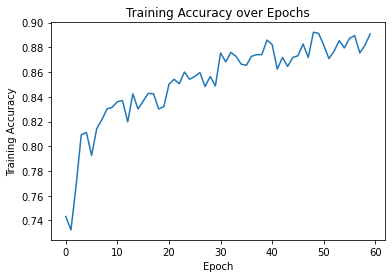

In [18]:
# Accuracy graph
acc_l = history.history['accuracy']
epochs_l = [i for i in range(len(acc_l))]
plt.plot(epochs_l, acc_l)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over Epochs")
plt.show()

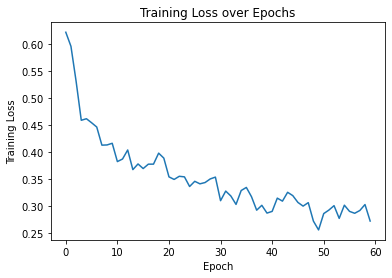

In [19]:
# Loss Figure
loss_l = history.history['loss']
epochs_l = [i for i in range(len(acc_l))]
plt.plot(epochs_l, loss_l)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

## Step 4
**Results and Analysis (35 pts)**

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Hyperparameter optimization procedure: I try different values of learning rate (0.0001, 0.001, 0.005, 0.01), different optimizers (Adam, RMSprop). I run a iteration over different value combinations. 

In [23]:
# Hyperparameter Tuning 
callbacks_l = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')]
eta_l = [0.0001, 0.001, 0.005, 0.01]
dropouts_l = [(True, True)]
optimizers_l = ["Adam", "RMSprop"]

permutations_l = list(itertools.product(*[eta_l, dropouts_l, optimizers_l]))
cur_best_model = (None, 0)
cur_best_his = None

accuracies_l = list()

for per in permutations_l:
    print("Hyperparameters: ", per)
    cur_model = model_build(per[0], True, True, per[2])
    cur_his = cur_model.fit(train_data, epochs=99, steps_per_epoch=len(train_data)/100, callbacks=callbacks_l)
    
    if cur_his.history["accuracy"][-1] > cur_best_model[1]:
        cur_best_model = (cur_model, cur_his.history["accuracy"][-1])
        cur_best_his = cur_his.history
    print()
        

Hyperparameters:  (0.0001, (True, True), 'Adam')
Epoch 1/99
68/68 [==============================] - 27s 375ms/step - loss: 0.5385 - accuracy: 0.7518
Epoch 2/99
68/68 [==============================] - 25s 367ms/step - loss: 0.5086 - accuracy: 0.7708
Epoch 3/99
68/68 [==============================] - 25s 367ms/step - loss: 0.5242 - accuracy: 0.7649
Epoch 4/99
68/68 [==============================] - 25s 366ms/step - loss: 0.5088 - accuracy: 0.7659
Epoch 5/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4723 - accuracy: 0.7880
Epoch 6/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4793 - accuracy: 0.7772
Epoch 7/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4769 - accuracy: 0.7844
Epoch 8/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4518 - accuracy: 0.7957
Epoch 9/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4517 - accuracy: 0.7957
Epoch 10/99
68/68 [=======================

68/68 [==============================] - 25s 361ms/step - loss: 0.4285 - accuracy: 0.8139
Epoch 21/99
68/68 [==============================] - 25s 362ms/step - loss: 0.4235 - accuracy: 0.8166
Epoch 22/99
68/68 [==============================] - 25s 362ms/step - loss: 0.4116 - accuracy: 0.8134
Epoch 23/99
68/68 [==============================] - 25s 363ms/step - loss: 0.4010 - accuracy: 0.8284
Epoch 24/99
68/68 [==============================] - 25s 362ms/step - loss: 0.4185 - accuracy: 0.8184
Epoch 25/99
68/68 [==============================] - 25s 362ms/step - loss: 0.3882 - accuracy: 0.8424
Epoch 26/99
68/68 [==============================] - 25s 361ms/step - loss: 0.4070 - accuracy: 0.8234
Epoch 27/99
68/68 [==============================] - 25s 362ms/step - loss: 0.3962 - accuracy: 0.8428
Epoch 28/99
68/68 [==============================] - 25s 362ms/step - loss: 0.4163 - accuracy: 0.8184
Epoch 29/99
68/68 [==============================] - 25s 362ms/step - loss: 0.4113 - accuracy:

68/68 [==============================] - 26s 372ms/step - loss: 0.3027 - accuracy: 0.8732
Epoch 42/99
68/68 [==============================] - 25s 369ms/step - loss: 0.3303 - accuracy: 0.8646
Epoch 43/99
68/68 [==============================] - 25s 369ms/step - loss: 0.2999 - accuracy: 0.8768
Epoch 44/99
68/68 [==============================] - 25s 370ms/step - loss: 0.3526 - accuracy: 0.8560
Epoch 45/99
68/68 [==============================] - 25s 370ms/step - loss: 0.3143 - accuracy: 0.8705
Epoch 46/99
68/68 [==============================] - 25s 370ms/step - loss: 0.3266 - accuracy: 0.8650
Epoch 47/99
68/68 [==============================] - 25s 368ms/step - loss: 0.3032 - accuracy: 0.8691
Epoch 48/99
68/68 [==============================] - 25s 369ms/step - loss: 0.3182 - accuracy: 0.8709
Epoch 49/99
68/68 [==============================] - 25s 370ms/step - loss: 0.2940 - accuracy: 0.8850
Epoch 50/99
68/68 [==============================] - 25s 370ms/step - loss: 0.2572 - accuracy:

68/68 [==============================] - 27s 368ms/step - loss: 1.3176 - accuracy: 0.6549
Epoch 2/99
68/68 [==============================] - 25s 367ms/step - loss: 0.5978 - accuracy: 0.7296
Epoch 3/99
68/68 [==============================] - 25s 366ms/step - loss: 0.5103 - accuracy: 0.7763
Epoch 4/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4595 - accuracy: 0.7917
Epoch 5/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4588 - accuracy: 0.7976
Epoch 6/99
68/68 [==============================] - 25s 370ms/step - loss: 0.4736 - accuracy: 0.7880
Epoch 7/99
68/68 [==============================] - 25s 369ms/step - loss: 0.4720 - accuracy: 0.7939
Epoch 8/99
68/68 [==============================] - 25s 368ms/step - loss: 0.4459 - accuracy: 0.8053
Epoch 9/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4221 - accuracy: 0.8148
Epoch 10/99
68/68 [==============================] - 25s 367ms/step - loss: 0.4204 - accuracy: 0.8152


68/68 [==============================] - 25s 365ms/step - loss: 0.3554 - accuracy: 0.8519
Epoch 58/99
68/68 [==============================] - 25s 365ms/step - loss: 0.3612 - accuracy: 0.8474
Epoch 59/99
68/68 [==============================] - 25s 366ms/step - loss: 0.3606 - accuracy: 0.8569
Epoch 60/99
68/68 [==============================] - 25s 365ms/step - loss: 0.3552 - accuracy: 0.8537

Hyperparameters:  (0.01, (True, True), 'Adam')
Epoch 1/99
68/68 [==============================] - 27s 369ms/step - loss: 1.7287 - accuracy: 0.6196
Epoch 2/99
68/68 [==============================] - 25s 369ms/step - loss: 0.6167 - accuracy: 0.6757
Epoch 3/99
68/68 [==============================] - 25s 368ms/step - loss: 0.5751 - accuracy: 0.7034
Epoch 4/99
68/68 [==============================] - 25s 368ms/step - loss: 0.5253 - accuracy: 0.7659
Epoch 5/99
68/68 [==============================] - 25s 369ms/step - loss: 0.5152 - accuracy: 0.7654
Epoch 6/99
68/68 [==============================] -

In [24]:
print(cur_best_model[0].optimizer)

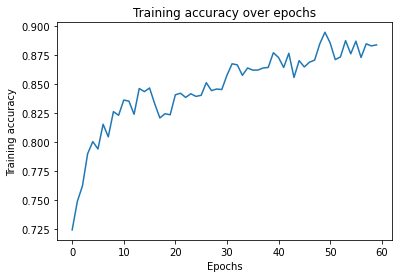

In [26]:
# Training accuracy figure for best model
accuracies_l = cur_best_his["accuracy"]
epochs_l = [i for i in range(len(accuracies_l))]

plt.plot(epochs_l, accuracies_l)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy over epochs")
plt.show()

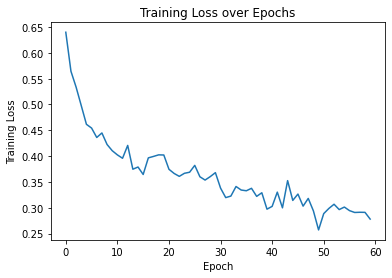

In [28]:
# Loss Figure
loss_l = cur_best_his['loss']
epochs_l = [i for i in range(len(acc_l))]
plt.plot(epochs_l, loss_l)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

## Step 5
**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Adam optimizer works better than RMSprop optimizer. Dropout helps prevent overfitting. If the learning rate value is too small, the performance is worse. 

In the future, I can try to use GPU for the training. 